# Imports

In [3]:
#%matplotlib notebook
%matplotlib inline 

import matplotlib
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import holoviews as hv

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pickle as pk
from time import time
import io

import datetime
import sys

from IPython.display import display, HTML
from ipywidgets import widgets
from ipywidgets.widgets import interact, interactive, interactive_output, fixed 
from ipywidgets.widgets import IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, RadioButtons, Dropdown, Button, HBox, VBox, Label

#  !pip3 install mpld3
# import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
# from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
from Cluster import * 

In [5]:
bd = BaseData('data_all_base')

reading in data from data_all_base ...
elapsed:  10.195267677307129


In [6]:
# run 
# clusdtypes should be in ['JRP1','ORP1','JWP1','OWP1','JRT1','ORT1','JWT1','OWT1']
# database JHU/OWID  (J/O) 
# report_correct T or F   (R/W)
# syncat peak/thresh  (P/T)
clusdtype='JRT1'
ClData = get_cluster_data(clusdtype)

reading in data from ./pks/data_cluster_JRT1.pk ...


In [7]:
exec(open('ClusterFit.py','r').read())

In [8]:
# changed to use model_fits_age : this is backwards compatible and only loads data if needed
import data_config
data_config.data_loaded = True    
from model_fits_age import *  # including ModelFit class definition. 

data already loaded, so no "from data import *" required.
making the models...
SC2UIR
SC2FIR
root model name SCFEIR not yet supported
SC3FEIR
SEI3R
SC3FEI3R
SC2FUIR
SC3FUEI3R
done with the models.


In [9]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in ClData.clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


198 countries with population data
common countries without population data []
74 cluster countries


In [10]:
[x for x in fullmodels]

['SC2UIR', 'SC2FIR', 'SC3FEIR', 'SEI3R', 'SC3FEI3R', 'SC2FUIR', 'SC3FUEI3R']

**Consensus clustering and map**

In [11]:
# from Consensus import *
# NB:  scoping problem seems to prevent import from working properly.
# instead use exec below.
country_display = None
class_display = None
display_countries = None
chosen_country = 'Australia'
current_country = 'Australia'
chosen_class = -1
current_class = -1
geog = None
geog1 = None
exec(open('Consensus.py','r').read());

In [12]:
#foo = Consensus(cases=['deaths','cases','cases_nonlinr'])
#clus = Consensus(ClData,cases = ['deaths','cases','cases_lin2020','cases_pwlfit','cases_nonlin','cases_nonlinr']);
#clus = Consensus(ClData,cases = ['deaths','cases','cases_nonlinr']);
clus = Consensus(ClData,cases = ['deaths','cases_nonlinr']);


74 countries
reference clustering (numbered from 0) is 7


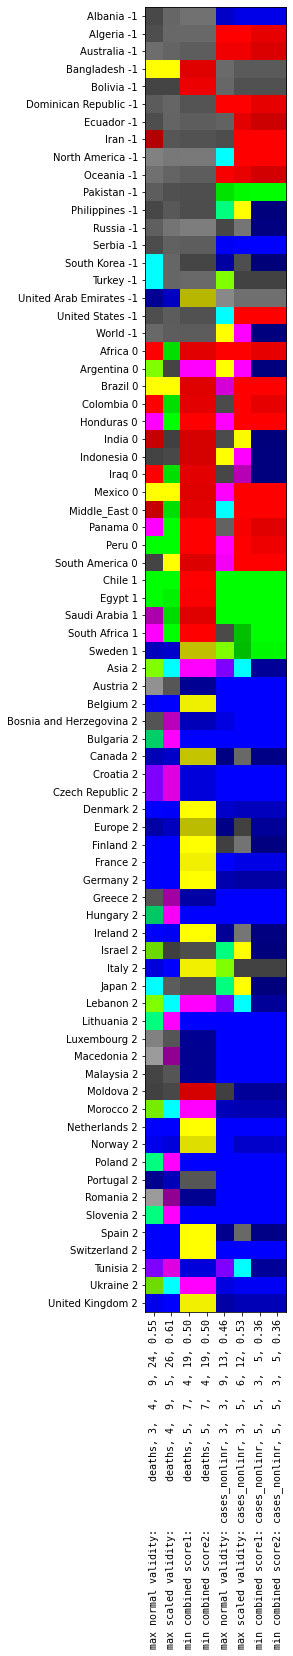

In [13]:
clus.scan() #clus.scan(diag=True) for diagnostic output
clus.make_clusters()
clus.swizzle(satthresh=0.6) # change threshold closer to 1 for more unclustered
clus.plot_swiz()
chosen_swdic = clus.swdic

In [14]:
satthresh_set = 0.6
def cluster_trace(cons, dataname='deaths', country='Australia', satthresh = 0.6):
    global satthresh_set,chosen_swdic,chosen_country
    if satthresh != satthresh_set:
        clus.swizzle(satthresh=satthresh) # change threshold closer to 1 for more unclustered
        chosen_swdic = clus.swdic
        satthresh_set = satthresh
        classes = sprintdic(chosen_swdic,chosen_country)
        class_display.value = classes
    try:
        if country in cons.countries:
            clus.plot_quantile(dataname,'own',country,title=False)
    except:
        clus.plot_quantile(dataname,'own','Australia',title=False)
        
display_countries = clus.countries        
country_display = interactive(cluster_trace,cons=fixed(clus),dataname=clus.cases,country=clus.countries,
                              satthresh= FloatSlider(value = 0.6,min=0.,max=1.0,step=0.01,description='cluster thresh',continuous_update=False));

In [15]:
classes = sprintdic(clus.swdic,chosen_country='Australia')
class_display = widgets.Textarea(value=classes,layout = widgets.Layout(height='320px'))

In [16]:
#display(country_display)
clus.make_map();

In [19]:
clus.map
clus.map.min_height=600;



.
..
0000**Alternate country_fit_trace by analogy to country_display_trace.**

Notes:
* `fit_trace()` creates the model, performs the fit, and produces the solveplot plots.
* `fit_output_text` is a global variable, set by scooping up all of stdout during fit report.

In [20]:
def data_choice(ts,strlist):
    #print(strlist)
    d = list(ts.keys())
    #print(d)
    notstrlist =['new','corrected','smoothed']
    igstrlist =['cumulative','raw','rough']
    for ns in notstrlist:
        if not any(ns in s for s in strlist):
            d = [x for x in d if not ns in x]
    #print(d)
    for s in strlist:
        if not s in igstrlist:
            if not (any('deaths' in s for s in strlist) and ('lin' in s)):
                d = [x for x in d if s in x]
                #print(s,d)
    return d

In [21]:
datasrcs_widget = RadioButtons(options=['jhu','owid'],description='data src',disabled=False,layout={'width': 'max-content'}) 
data_1_widget = RadioButtons(options=['deaths','confirmed'],description='data type',disabled=False,layout={'width': 'max-content'}) 
data_2_widget = RadioButtons(options=['new','cumulative'],description='integration',disabled=False,layout={'width': 'max-content'})
data_3_widget = RadioButtons(options=['corrected','raw'],description='correction',disabled=False,layout={'width': 'max-content'})
data_4_widget = RadioButtons(options=['smoothed','rough'],description='smoothing',disabled=False,layout={'width': 'max-content'})

datanames_widget = Dropdown(options=data_choice(bd.covid_ts,['deaths','new','corrected','smoothed','raw']),
                            description='data chc',disabled=False,layout={'width': 'max-content'}) 

def datachoice_update(*args):
    curr_option = datanames_widget.value
    datanames_widget.options=data_choice(bd.covid_ts,[data_1_widget.value,data_2_widget.value,
                                    data_3_widget.value,data_4_widget.value]) 
    if not curr_option in datanames_widget.options: 
        datanames_widget.value=datanames_widget.options[0]
        
data_1_widget.observe(datachoice_update,'value')
data_2_widget.observe(datachoice_update,'value')
data_3_widget.observe(datachoice_update,'value')
data_4_widget.observe(datachoice_update,'value')

dcbox = VBox([datasrcs_widget,data_1_widget,data_2_widget,data_3_widget,data_4_widget])

In [22]:
countries_common = bd.countries_common  
countries_widget = Dropdown(options=countries_common,description='countries',layout={'width': 'max-content'},value=chosen_country)
modelnames_widget = Dropdown(options=possmodels,description='model',layout={'width': 'max-content'},value='SC2UIR')
modelage_widget = Dropdown(options=[1,4,8,16],description='age grps',layout={'width': 'max-content'},value=1)
fittypes = ['leastsq','nelder','differential_evolution','nelder','slsqp','shgo','cobyla','lbfgsb','bfgs','basinhopping','dual_annealing']
fittypes_widget = Dropdown(options=fittypes,description='fit meth',layout={'width': 'max-content'},value='leastsq')
fit_output_text = 'Fit output will be displayed here.'
fit_display_widget = widgets.Textarea(value=fit_output_text,disabled=False,layout = widgets.Layout(height='320px',width='520px'))

def swizzle_update(*args):
    country_display


#def datanames_update(*args):
#    if datasrcs_widget.value == 'jhu':
#        datanames_widget.options = list(bd.covid_ts.keys())
#    elif datasrcs_widget.value == 'owid':
#        datanames_widget.options = list(bd.covid_owid_ts.keys()) 
#datasrcs_widget.observe(datanames_update,'options')

def countries_update(*args):
    global chosen_country,chosen_class,countries_common
    #if chosen_country in countries_common:
    countries_widget.value = country_display.children[1].value
    # else:
    # countries_widget.value = countries_widget.value
    class_display.value = sprintdic(clus.swdic,chosen_country=countries_widget.value)

country_display.children[1].observe(countries_update,'value')

def common_trace(datasrc = 'jhu', dataname='deaths',country='Australia'):
    global bd,countries_common
    if country in countries_common:
        if datasrc == 'jhu':
            ts = bd.covid_ts
        elif datasrc == 'owid':
            ts = bd.covid_owid_ts
        else:
            print('Error in datasrc')
        if dataname in ts:    
            if 'deaths' in dataname:
                plt.plot(ts[dataname][country],color='red')
            elif 'confirmed' in dataname:
                plt.plot(ts[dataname][country],color='green')
        else:
            print('dataname not found',dataname)
            
country_display_trace = interactive_output(common_trace,{'datasrc':datasrcs_widget,'dataname':datanames_widget,'country':countries_widget});

In [23]:
def allsliderparams(self,params_init_min_max={}):
    """
        construct dictionary of slider widgets corresponding to 
        input params_init_min_max is the dictionary of tuples for parameter optimization (3 or 4-tuples)
        pimm is short name for params_init_min_max
    """
    pimm = params_init_min_max
    if pimm == {}:
        print('missing non empty dictionary params_init_min_max')
        return
    elif len(pimm[list(pimm.keys())[0]]) != 4:
        print('dictionary params_init_min_max must contain tuples with 4 entries (val,min,max,step)')
        return
    slidedict = {}
    slider_layout = Layout(width='400px', height='12px')
    style = {'description_width': 'initial'}
    modelname=self.modelname
    slidedict.update({'param_class':fixed('base')})
    slidedict.update({'figsize':fixed((8,5))})
    for pm in pimm:
        if ((not 'Caution' in pm) or 'C' in modelname) and ((not 'Econom' in pm) or 'U' in modelname) and ((not 'Young' in pm) or '_A' in modelname):
            slidedict.update({pm:FloatSlider(min=pimm[pm][1],max=pimm[pm][2],step=pimm[pm][3],value=pimm[pm][0],description=pm,
                            style=style,
                            layout=slider_layout,
                            continuous_update=False,readout_format='.3f')})
    return slidedict 

In [24]:
modelname = 'SC3FUEI3R'
MyModel = ModelFit(modelname,basedata=bd,country='Australia',run_id="_test1",data_src='jhu')
params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed, Widget
#sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
sliderparams = allsliderparams(MyModel,params_init_min_max_slider)

In [25]:
#def fit_trace(modelname='SC3EI3R',fittype='leastsq',datasrc='jhu',dataname='deaths',country='Australia'):
def fit_trace(modelname='SC3FUEI3R',agestructure=1,fittype='leastsq',datasrc='jhu',country='Australia'):
    global MyModel
    if int(agestructure) > 1 and modelname in ['SIR','SC2IR','SC2FIR','SEI3R','SC3EI3R','SC3FEI3R','SC3UEI3R','SC3FUEI3R'] :
        modelname_a = modelname+'_A'+str(agestructure)
    elif int(agestructure) > 1:  # age structure not yet implemented for this model type
        modelname_a = modelname
        agestructure=1
        modelage_widget.value = agestructure
    else:
        modelname_a = modelname
    try:
        old_stdout = sys.stdout
        sys.stdout = mystdout = io.StringIO()
        ###############################################
        ## do the fit
        #MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
        MyModel = ModelFit(modelname_a,basedata=bd,country=country,run_id="_test1",data_src=datasrc)
        paramtype = 'ode'
        if paramtype == 'ode':
            params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
            MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
            MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
        elif paramtype == 'base':
            params_init_min_max = default_fit_params(MyModel.sbparams,MyModel.cbparams,MyModel.fbparams)
            params_in = base2params(MyModel.sbparams,MyModel.cbparams,MyModel.fbparams,modelname_a)
            # need to check transfer of parameteres and compatibility
        if 'logI_0' in params_init_min_max:
            MyModel.set_I0(params_init_min_max['logI_0'][0])
        fit_display_widget.value = "Processing fit, please wait ..."
        
        fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
        #fit_ctrl = {}
        # MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
        # MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
        #MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

        if fittype=='leastsq':
            MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
        else:
            MyModel.fit(params_init_min_max,fit_method=fittype,fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False)
        #MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)
        # MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
        ax=MyModel.solveplot(['deaths','confirmed','caution_fraction','economy'],
                      datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                      mag={'deaths':30.},newplot=True,figsize=(8,5));
        fit_display_widget.value = mystdout.getvalue()   #  fit_output_widget global.
    finally:
        sys.stdout = old_stdout

#country_fit_trace = interactive_output(fit_trace,{'modelname':modelnames_widget,'fittype':fittypes_widget,'datasrc':datasrcs_widget,'dataname':datanames_widget,'country':countries_widget});
country_fit_trace = interactive_output(fit_trace,{'modelname':modelnames_widget,'agestructure':modelage_widget,'fittype':fittypes_widget,'datasrc':datasrcs_widget,'country':countries_widget});

In [26]:
if sliderparams:
    w=interactive_output(MyModel.slidefitplot,sliderparams)
    sliders=VBox([w1 for w1 in list(sliderparams.values()) if isinstance(w1,Widget)])
    slbox=HBox([w,sliders])

In [28]:
cbox = VBox([datanames_widget,countries_widget,country_display_trace])  
choicebox = HBox([modelnames_widget, modelage_widget, fittypes_widget])
sbox = VBox([choicebox,country_fit_trace])
myhbox1 = HBox([country_display,class_display,dcbox,cbox])
myhbox2 = HBox([sbox,VBox([Label('Fit output data'),fit_display_widget]),slbox])
#myhbox2 = HBox([sbox])
#myhbox2 = [country_fit_trace]
#VBox([mybox,clus.map]) 
#VBox([myhbox1,myhbox2,clus.map])
VBox([myhbox1,myhbox2])

In [29]:
clus.map


Map(center=[20, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [21]:
fp = default_fit_params(MyModel.sbparams,MyModel.cbparams,MyModel.fbparams)

In [24]:
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed, Widget
#sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
params_init_min_max_slider = fp.copy()
# params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)
sliderparams = allsliderparams(MyModel,params_init_min_max_slider)

In [25]:
if sliderparams:
    w=interactive_output(MyModel.slidefitplot,sliderparams)
    sliders=VBox([w1 for w1 in list(sliderparams.values()) if isinstance(w1,Widget)])
    display(HBox([w,sliders]))

In [26]:
MyModel.model.modelname

'SC2UIR'

In [27]:
MyModel.soln[:,7]

array([1.        , 0.99999861, 0.9999938 , 0.9999843 , 0.99996835,
       0.9999435 , 0.99990633, 0.99985211, 0.99977432, 0.99966396,
       0.99950878, 0.99929222, 0.99899218, 0.9985797 , 0.99801781,
       0.99726081, 0.99625481, 0.99494015, 0.99325619, 0.99114859,
       0.98857764, 0.98552546, 0.98199968, 0.97803229, 0.97367429,
       0.9689882 , 0.96404054, 0.958896  , 0.95361361, 0.9482449 ,
       0.94283338, 0.93741493, 0.93201862, 0.92666764, 0.92138033,
       0.916171  , 0.91105069, 0.90602785, 0.90110882, 0.89629825,
       0.89159945, 0.88701466, 0.88254527, 0.87819197, 0.8739549 ,
       0.86983376, 0.86582789, 0.86193634, 0.85815796, 0.85449136,
       0.85093504, 0.84748736, 0.84414661, 0.84091095, 0.83777853,
       0.83474742, 0.83181567, 0.82898127, 0.82624222, 0.82359648,
       0.821042  , 0.81857674, 0.81619863, 0.8139056 , 0.8116956 ,
       0.80956657, 0.80751644, 0.80554317, 0.80364471, 0.80181901,
       0.80006407, 0.79837784, 0.79675834, 0.79520356, 0.79371

In [28]:
(len(MyModel.soln[:,7]),len(MyModel.tsim[1:]))

(306, 306)

In [29]:
MyModel.initial_values

(array([9.999997e-01, 3.000000e-07, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 0)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
params_init_min_max_slider

**NOTE: MyModel is global variable set to last model fit.  This means we can dig into it if desired, e.g:**

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
print(pars)

for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

# Fit 4 countries...

In [ ]:
possmodels

# From old Fit notebook...

In [ ]:
modelname = 'SIR'
country='Australia'
MyModel = ModelFit(modelname,basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='jhu')
params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
if 'logI_0' in params_init_min_max:
    MyModel.set_I0(params_init_min_max['logI_0'][0])
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)



**Some preliminary data plots**

In [ ]:
plt.plot(bd.new_deaths_spm_jhu['Germany'])

In [ ]:
plt.plot(bd.covid_ts['new_deaths']['Germany'])

In [ ]:
plt.plot(bd.covid_ts['new_deaths_smoothed']['Germany'])

In [ ]:
plt.plot(bd.covid_ts['new_deaths_corrected_smoothed']['Germany'])

In [ ]:
plt.plot(bd.covid_owid_ts['new_deaths_corrected_smoothed']['Germany'])

In [ ]:
plt.plot(ClData.clusdata_all['deaths']['Germany'])
plt.plot(ClData.deaths_raw['Germany']);

In [ ]:
plt.plot(ClData.clusdata_all['cases']['Germany'])
plt.plot(ClData.clusdata_all['cases_nonlinr']['Germany']);

In [ ]:
[x for x in dir(ClData) if '__' not in x]

In [ ]:
[x for x in ClData.clusdata_all if '__' not in x]

# Use `Modelfit.solvefit()` with `lmfit`

In [ ]:
bd = BaseData('data_all_base')

In [ ]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
# exec(open('model_fits_nodata.py','r').read())
exec(open('ModelFit.py','r').read())

In [ ]:
# check that now all country names are strings : jhu data now only has common countries (191)
ts=bd.covid_ts
ts.keys()
for dt in ts.keys():
    if 'Germany' in ts[dt].keys():
        print(dt,'str')
    elif ('Germany','') in ts[dt].keys():
        print(dt,"(str,'')")
    else:
        print(dt,'no country key')

In [ ]:
country = 'Germany'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='jhu')

In [ ]:
# restricted range:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}

params_init_min_max = {
                   "beta_1": (0.4, 0.0, 1.2,0.001),
                   "mu": (.05,0.0,0.15,0.001),
                   "c_0": (0.1, 0.0, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 55., 0.01), 
                   "logI_0": (-6.,-12.,-3.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:

fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])


In [ ]:
lmfit.report_fit(MyModel.fit_output)

In [ ]:
start = time()
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
print('Elapsed: ',time()-start)

In [ ]:
dir(MyModel)

In [ ]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

In [ ]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

In [ ]:
# outfit.params
MyModel.params

## Trying solve4fitlog 

In [ ]:
country = 'Germany'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='jhu')

In [ ]:
params_init_min_max = {
                   "beta_1": (0.4, 0.0, 0.8,0.001),
                   "mu": (.05,0.0,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                   "logI_0": (-6.,-9.,-3.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

In [ ]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

In [ ]:
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

In [ ]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

### SEI3R

In [ ]:
country = 'Germany'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SEI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='jhu')

In [ ]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.8,0.001),
                   "mu": (.05,0.0,0.15,0.001),
                   #"c_0": (0.1, 0.05, 1.0,0.001), 
                   #"c_1": (0.07, 0.0, 0.1,0.001),
                   #"c_2": (5., 1., 8., 0.01), 
                   "logI_0": (-6.,-9.,-3.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

In [ ]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

In [ ]:
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

In [ ]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
print(pars)
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
MyModel.prparams()

In [ ]:
np.power(10,3)

## Trying different fitting methods...

see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html) on fitting methods for the list.

In this section I am using the same basic template to repeat the basic fitting operation with different fitting methods.

All seem to work.  Some comments:
* some (e.g. leastsq, differential_evolution) seem to hop all over the place, giving wildly varying residual socre and param convergence.
* some (powell, cobyla)seem to converge fast at beginning, with a slow tail (view residual plot with semilog)
* initially chose nelder, because of consistent gradual convergence.
* then switched back to leastsq as it gave fast reliable results after other problems had been resolved

## USA

### just deaths

NB: must do owid, key error with jhu

In [ ]:
[x for x in bd.covid_ts['deaths'] if 'US' in x]

In [ ]:
country = 'United States'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='owid')

In [ ]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   #"mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   #"c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

In [ ]:
MyModel.solveplot(['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],mag={'deaths':30.})

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

In [ ]:
# outfit.params
MyModel.params

### fit deaths+confirmed

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',basedata=bd.covid_ts,country=country,run_id="_test1",data_src='owid')

In [ ]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

### fit deaths+ testing adjusted confirmed

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test1",data_src='owid')

In [ ]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:
testdata = covid_owid_ts['confirmed_corrected_smoothed']
print(len(testdata),len(testdata['United States']))
testdatar = covid_owid_ts['confirmed_nonlinr_corrected_smoothed']
print(len(testdatar),len(testdatar['United States']))


In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_nonlinr_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

### fit deaths only

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

# ModelFit with lmfit integrated

## SC3EI3R 

### Test on Germany with method Nelder

In [ ]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [ ]:
[x for x in bd.covid_owid_ts['deaths']]

In [ ]:
bd.covid_owid_ts['deaths']['dates'][-1]

In [ ]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_test2")

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

#### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Test on USA

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2",new=True)

In [ ]:
params_init_min_max = {"beta_1": (0.4, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
countries[0]

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0.0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.4, 0.1, 0.6),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
        MyModel.solveplot(species=['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
params_init_min_max = {"beta_1": (0.4, 0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

[[Variables]]
    beta_1:  0.32665845 +/- 0.46153068 (141.29%) (init = 0.2)
    mu:      0.09205437 +/- 0.06980213 (75.83%) (init = 0.1)
    c_0:     0.18519038 +/- 0.21390488 (115.51%) (init = 0.1)
    c_1:     0.16174352 +/- 0.16259196 (100.52%) (init = 0.05)
    c_2:     9.32518629 +/- 6.93746369 (74.39%) (init = 2)
    logI_0: -6.00779344 +/- 2.75916716 (45.93%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, c_0) = -0.441
    C(beta_1, c_2) =  0.229
    C(c_1, c_2)    =  0.225
    C(c_0, c_1)    =  0.124
    C(beta_1, mu)  = -0.108
    C(mu, c_0)     =  0.107

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

#### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Test Scan class

In [ ]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [ ]:
foo = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files



In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']
short_countries = ['United States','Spain','Peru']

In [ ]:
pinit = {"beta_1": (0.2, 0., 2.),
         "mu": (.1,0.,.2),
         "c_0": (0.1, 0., 1.0),
         "c_1": (0.07, 0.0, 0.5),
         "c_2": (5., 2.,20.),
         "logI_0": (-6.,-10.,0.0)}

foo = Scan(countries=short_countries,params_init_min_max=pinit, modelname='SC3EI3R',
           basedata=bd,data=bd.covid_owid_ts,country=country,run_id='_short',new=True,data_src='owid') # run_id labels parameter dump files



In [ ]:
foo.scan()

In [ ]:
foo.run_id

### Country scan

**Deaths only**

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        
        MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,fit_method='slsqp',diag=False,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
        MyModel.solveplot(species=['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

In [ ]:
len(cluster_countries)

In [ ]:
[x for x in dir() if 'countries' in x]

**deaths only, graph confirmed with nonlinr corrected**

In [ ]:
[x for x in bd.covid_owid_ts]

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,2.6*max_rows))

start = time()

# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        
        MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,fit_method='slsqp',diag=False,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
        MyModel.solveplot(species=['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()
print('Elapsed time ',time()=start)

### country scan, cluster countries, death fit only.

In [ ]:

#countries = short_countries
countries = cluster_countries
cnt=0
max_cols=8
max_rows=int(len(countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,2.6*max_rows))

scan_params = {}
scan_fitdata = {}
start = time()
# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


#for idx, country  in enumerate(short_countries):
for idx, country  in enumerate(countries):
    print(idx,country)
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,fit_method='slsqp',diag=False,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],report=False)
        MyModel.solveplot(species=['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)  
        scan_params[country] = MyModel.all_params
        scan_fitdata[country] = MyModel.fit_output
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()
print('Elapsed time for ',len(countries),'countries:',time()-start)

In [ ]:
scan_params['Germany']

In [ ]:
scan_fitdata['Germany']

In [ ]:
run_id=MyModel.modelname+'_'+'_'.join(MyModel.fit_targets)+'_'+'owid'
run_id

In [ ]:
scan_all = {}
scan_all['params'] = scan_params.copy()
scan_all['fitdata'] = scan_fitdata.copy()
pk.dump(scan_all,open(run_id+'.pk','wb'))


## Try for U model class

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3UEI3R',country=country,run_id="_test3")

In [ ]:
params_init_min_max = {"beta_1": (0.37526113317338305, 0., 2.,0.001),
                       "alpha": (0.2, 0., 1.,0.001),
                       "mu": (0.11549404287611789,0.,.2,0.001),
                       "c_0": (0.2583441976053431, 0., 1.0,0.001),
                       "c_1": (0.03763741590817468, 0.0, 0.5,0.001),
                       "c_2": (3.620445327728954, 2.,20.,0.01),
                       "k_u": (1.0/5.0,0,1,0.001),
                       "k_1": (1.0/90.0,0.0,1.0,0.001),
#                       "k_w": (1.0/90.0,0.0,1.0),
#                       "kappa": (0.5,0,1.0),
                       "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
for pp in params_init_min_max:
    if pp in MyModel.params:
        print(pp,MyModel.params[pp],params_init_min_max[pp])
    

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Country scan

In [ ]:
countries = [c for c in clusdata_all['deaths']]
len(countries)

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
MyModel = ModelFit('SC3UEI3R',country=short_countries[0],run_id="_scan")

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [ ]:
MyModel.fit(params_init_min_max,diag=False)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0.1, 0.5),
                       "mu": (.1,0.05,.2),
                       "c_0": (0.1, 0.05, 0.5),
                       "c_1": (0.07, 0.02, 0.2),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3UEI3R',country=country,run_id="_scan",data_src='jhu') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths'],fit_data='deaths_corrected_smoothed')
        MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3UEI3R.pdf')
plt.show()

# Pygom + minimize with sensitivities

## Previous pygom fitting example from `Caution_paper_Fitting`

In [ ]:
test_country = 'Germany'
fitdata = covid_ts['new_deaths_corrected_smoothed'][(test_country,'')]
t = list(range(len(fitdata)))

In [ ]:
plt.plot(fitdata);

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
SC3EI3R_model.parameters = {'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}

In [ ]:
np.shape(t)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
I0 =10**-7
x0_SC3EI3R = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
SC3EI3R_model.parameters={'beta_1': 0.41, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.0166, 'c_2': 10000.0}
cautionparams = list(params.values())[-4:-1]
theta = [0.40,0.1,0.3,0.0167,1000.] # cautionparams
# boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(6000.,12000.)]
boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(600.,1200.)]
# set up optimization function with cost and sensitivity (Jacobian)
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=fitdata[1:],
                      # state_weight=[1.,10.],state_name=['R','D'],
                        state_weight=[1.],state_name=['D'],
                        target_param=['beta_1','mu','c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[I0],
                bounds=boxBounds+[(0.00000001,0.000001)],
                # method='BFGS',
                method='SLSQP',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                #options={'disp':True})
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

# Fitting base params

In [ ]:
[x for x in dir(MyModel) if 'param' in x]

In [ ]:
MyModel.prparams()


In [ ]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

## parameter setup for 3 rounds of fitting with standard values (use copy if want to edit)

In [ ]:
params_init_min_max_1 = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [ ]:
params_init_min_max_1U = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [ ]:
params_init_min_max_2 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001)
}

In [ ]:
params_init_min_max_2U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01)
}

In [ ]:
params_init_min_max_3 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001)
}

In [ ]:
params_init_min_max_3U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01),
    'EconomicStriction': (30,15,90,0.01),
    'EconomicRelaxation': (60,15,90,0.01),
    'EconomicCostOfCaution': (0.5,0.1,0.9,0.001)
}

## Example Germany

In [ ]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test3")

In [ ]:
MyModel.fit(params_init_min_max_1,param_class='base', fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
# the optimized parameters from stage 1 are transferred to initial values for these parameters
# in the larger set of parameters in stage 2
params_init_min_max_2 = MyModel.transfer_fit_to_params_init(params_init_min_max_2)
MyModel.fit(params_init_min_max_2,param_class='base', fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

### Death only

In [ ]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test4")

In [ ]:
MyModel.fit(params_init_min_max_1,param_class='base', fit_method='leastsq',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
# the optimized parameters from stage 1 are transferred to initial values for these parameters
# in the larger set of parameters in stage 2
params_init_min_max_2 = MyModel.transfer_fit_to_params_init(params_init_min_max_2)
MyModel.fit(params_init_min_max_2,param_class='base', fit_method='nelder',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

### slider plot for base params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_2)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('base'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_2_slider = params_init_min_max_2.copy()
params_init_min_max_2_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_2_slider)

In [ ]:
MyModel.prparams()

### slider plot for ode params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
# define with 4th tuple elt step size for sliders
params_init_min_max = {"beta_1": (0.487, 0., 1., 0.001),
                       "alpha": (0.2,0.,1.,0.001),
                       "mu": (0.057,0.,.2,0.001),
                       "c_0": (0.1, 0., 1.0,0.001),
                       "c_1": (0.011, 0.0, 0.5,0.001),
                       "c_2": (4.15, 2.,20.,0.01),
                       "logI_0": (-6.85,-10.,0.0, 0.01)}

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
MyModel.prparams()